In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

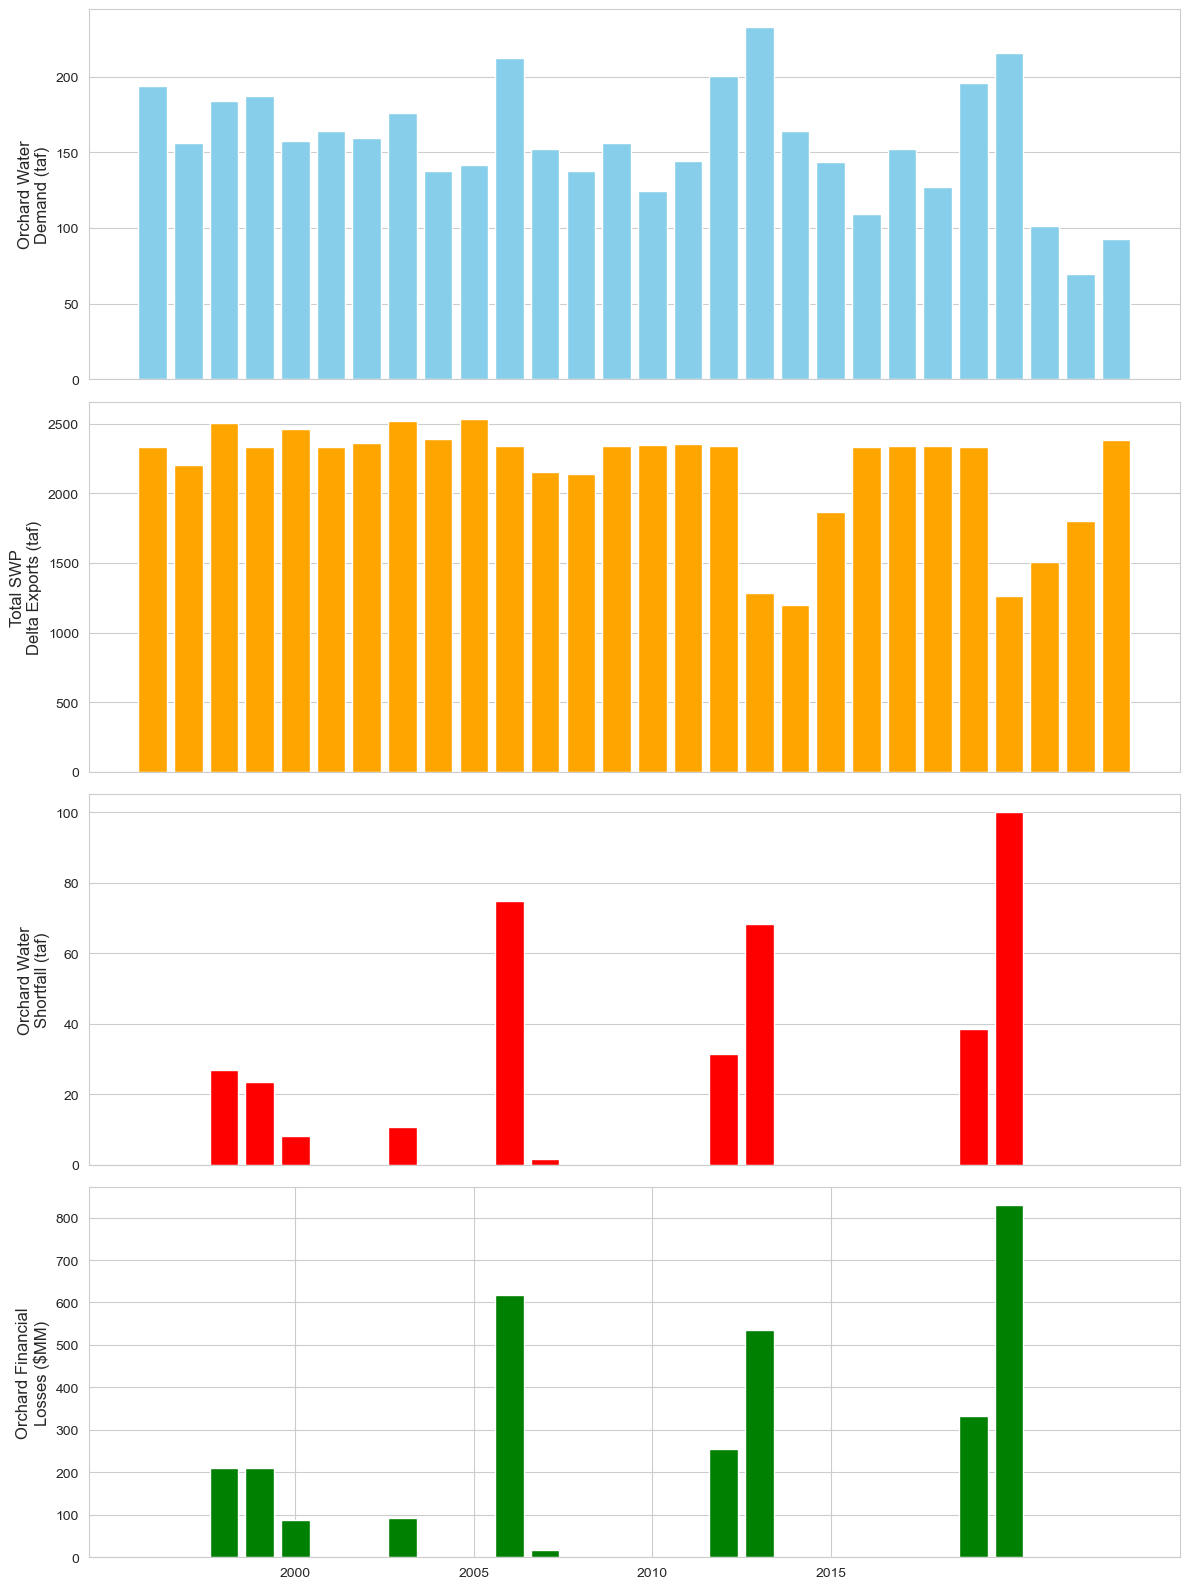

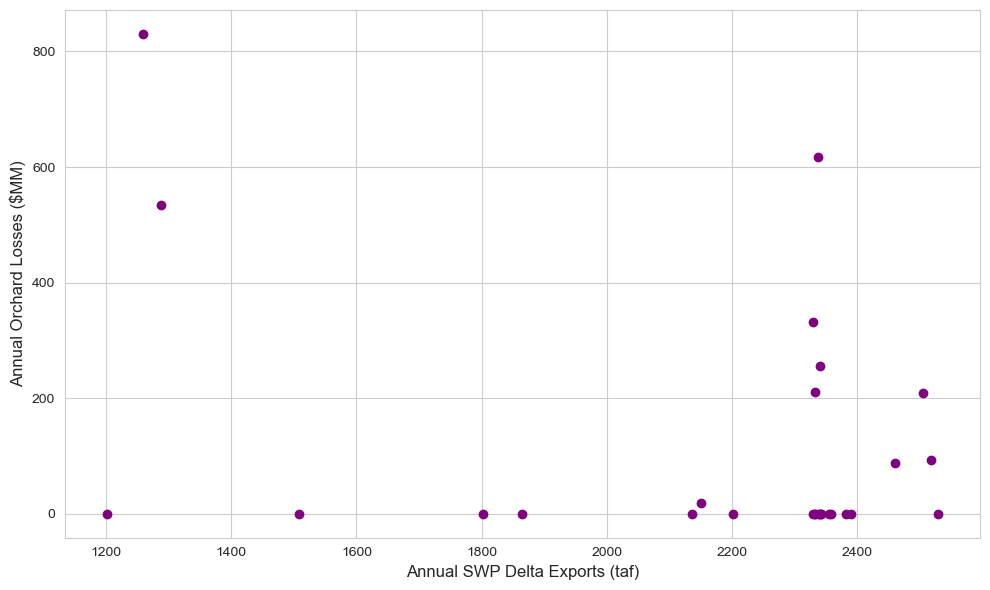

In [2]:
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily = get_results_sensitivity_number_outside_model(output_file, '')
validation = datDaily
list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']

# Initialize total acreage for each crop
total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0

# Initialize cost and revenue from agricultural production
# Immature pistachios (by year of immaturity)
cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
immature_acres_pistachio = np.zeros(6)

# Mature pistachios
mature_operating_costs_pistachio = 3210
mature_revenues_pistachio = 5997

# Immature almonds
cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
immature_acres_almond = np.ones(5) * total_acres_almond / 25.0

# Mature almonds
mature_operating_costs_almond = 3987
mature_revenues_almond = 7500

# Almonds stop being productive after 25 years
acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0

annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()

annual_deliveries = 0
annual_pumping = 0
annual_exchanged = 0

for wu in list_of_water_users:
    delivery_col = f'{wu}_tableA_delivery'
    pumping_col = f'{wu}_pumping'
    exchanged_col = f'{wu}_exchanged_GW'
    
    if not all(col in validation.columns for col in [delivery_col, pumping_col, exchanged_col]):
        raise ValueError(f"One or more required columns for water user '{wu}' are missing.")

    deliveries = validation[delivery_col].resample('AS-OCT').max()
    pumping = validation[pumping_col].resample('AS-OCT').sum()
    exchanged = validation[exchanged_col].resample('AS-OCT').max()
    
    annual_deliveries += deliveries
    annual_pumping += pumping
    annual_exchanged += exchanged

# the percent of land fallowed is equal to the percent of irrigation
# calfews determines is met through 'pumping'
# we assume there is no GW pumping available in these lands, so 
# this land must be fallowed. this can be adjusted to reflect pumping 'limits'
total_water_demand = annual_deliveries + annual_pumping
adjusted_water_demand = np.zeros(len(total_water_demand))
adjusted_shortfall = np.zeros(len(total_water_demand))
annual_cost = np.zeros(len(total_water_demand))

# Loop through each year of the simulation
for year_sim in range(len(total_water_demand)):
    # we assume that any fallowed orchards are immediately replanted
  # but immature acres use 25% of the water that mature acres use
  # so any 'fallowed' acres must first account for the lower water demands
  # of immature acres (this is not included in CALFEWS model so must be post-processed)
    immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
    adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
   
    adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
    pct_fallowed = adjusted_shortfall[year_sim] / adjusted_water_demand[year_sim] if adjusted_water_demand[year_sim] > 0 else 0.0
    fallowed_almonds = pct_fallowed * total_acres_almond
    fallowed_pistachios = pct_fallowed * total_acres_pistachio
    
  # cost of fallowing is equal to (revenue - cost) for mature orchards
  # minus (revenue - cost) for immature orchards
  # since orchards take 6 years to mature, costs accrue across 6 years
  # revenue - cost for immature orchards changes based on the age
    for year_loss in range(len(cost_per_acre_pistachio)):
        discounted_factor = 1.05 ** year_loss
        revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                        mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
        annual_cost[year_sim] += (fallowed_pistachios * revenue_loss) / discounted_factor
    
  # cost of fallowing is the same for almonds, except
  # we need to account for the fact that all 25 year old
  # almond trees are fallowed regardless of irrigation availability
    total_fallowed_almonds = 0.0
    for age_year in reversed(range(25)): # fallow oldest almond trees first, loop through ages backwards
        # if fallowed_almonds <= 0:
        #     break
        age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds)
        # if age_fallowed <= 0:
        #     continue
        
        for year_loss in range(len(cost_per_acre_almond)):
            expected_age = age_year + year_loss
            discounted_factor = 1.05 ** year_loss
            if expected_age < 25:
                revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] -
                                mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
            else:
                # if the tree would have been fallowed, compare revenues/costs to younger immature tree 
                adjusted_year = expected_age - 25
                if adjusted_year < len(revenue_per_acre_almond):
                    revenue_loss = (revenue_per_acre_almond[adjusted_year] +
                                    cost_per_acre_almond[year_loss] -
                                    cost_per_acre_almond[adjusted_year] -
                                    revenue_per_acre_pistachio[year_loss])
                else:
                    revenue_loss = 0  # Handle cases where adjusted_year exceeds list length
            annual_cost[year_sim] += (age_fallowed * revenue_loss) / discounted_factor
        # record the fallowing in the correct age group
        acres_by_year_almond[age_year] -= age_fallowed
        fallowed_almonds -= age_fallowed
        total_fallowed_almonds += age_fallowed
    
    # Update pistachio acres
    total_acres_pistachio -= fallowed_pistachios
    total_acres_pistachio += immature_acres_pistachio[-1]
    
    # Age immature pistachios
    immature_acres_pistachio[1:] = immature_acres_pistachio[:-1]
    immature_acres_pistachio[0] = fallowed_pistachios

    total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
    acres_by_year_almond[1:] = acres_by_year_almond[:-1]
    acres_by_year_almond[0] = immature_acres_almond[-1]
    
    # Age immature almonds
    immature_acres_almond[1:] = immature_acres_almond[:-1]
    immature_acres_almond[0] = total_fallowed_almonds

start_year = annual_water_demand_year_start = annual_water_demand_year_end = None

if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
    start_year = annual_delta_exports.index.year.min()
    end_year = annual_delta_exports.index.year.max()
else:
    start_year = 1997
    end_year = 2016 

years = np.arange(start_year, end_year + 1)

fig, ax = plt.subplots(4, figsize=(12, 16))

ax[0].bar(years, adjusted_water_demand, color='skyblue')
ax[1].bar(years, annual_delta_exports, color='orange')
ax[2].bar(years, adjusted_shortfall, color='red')
ax[3].bar(years, annual_cost / 1e6, color='green')

ax[0].set_ylabel('Orchard Water\nDemand (taf)', fontsize=12)
ax[1].set_ylabel('Total SWP\nDelta Exports (taf)', fontsize=12)
ax[2].set_ylabel('Orchard Water\nShortfall (taf)', fontsize=12)
ax[3].set_ylabel('Orchard Financial\nLosses ($MM)', fontsize=12)


for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_xticklabels('')


ax[3].set_xticks([2000, 2005, 2010, 2015])
ax[3].set_xticklabels([2000, 2005, 2010, 2015])

plt.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(annual_delta_exports, annual_cost / 1e6, marker='o', color='purple')
ax.set_ylabel('Annual Orchard Losses ($MM)', fontsize=12)
ax.set_xlabel('Annual SWP Delta Exports (taf)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


2024-10-01   -60.533593
2025-10-01   -85.708175
2026-10-01   -65.645337
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -79.046189
2026-10-01    -4.225112
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -54.588730
2026-10-01   -61.196933
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -77.624505
2026-10-01   -75.003524
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -42.717838
2026-10-01   -27.494346
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -98.845068
2026-10-01   -82.220893
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -52.795271
2026-10-01   -67.335224
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -59.948382
2026-10-01   -68.549430
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -49.643138
2026-10-01   -41.897646
Freq: AS-OCT, dtype: float64
2024-10-01   -60.533593
2025-10-01   -77.672833
2026-10-01   -79.346478
Freq: AS-OCT, dtype

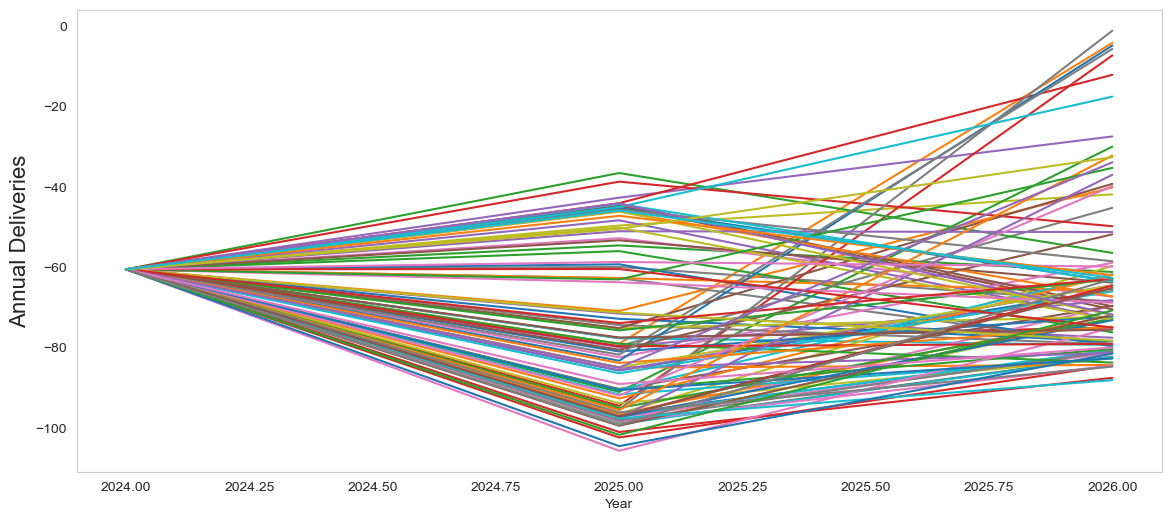

In [3]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_deliveries = datDaily['wonderful_BLR_tableA_carryover'] + datDaily['wonderful_LHL_tableA_carryover'] + datDaily['wonderful_BDM_tableA_carryover']
    
    yearly_sum = annual_deliveries.resample('AS-OCT').max()
    data_dict[f'Trace {i}'] = yearly_sum.values
    print(yearly_sum)
data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

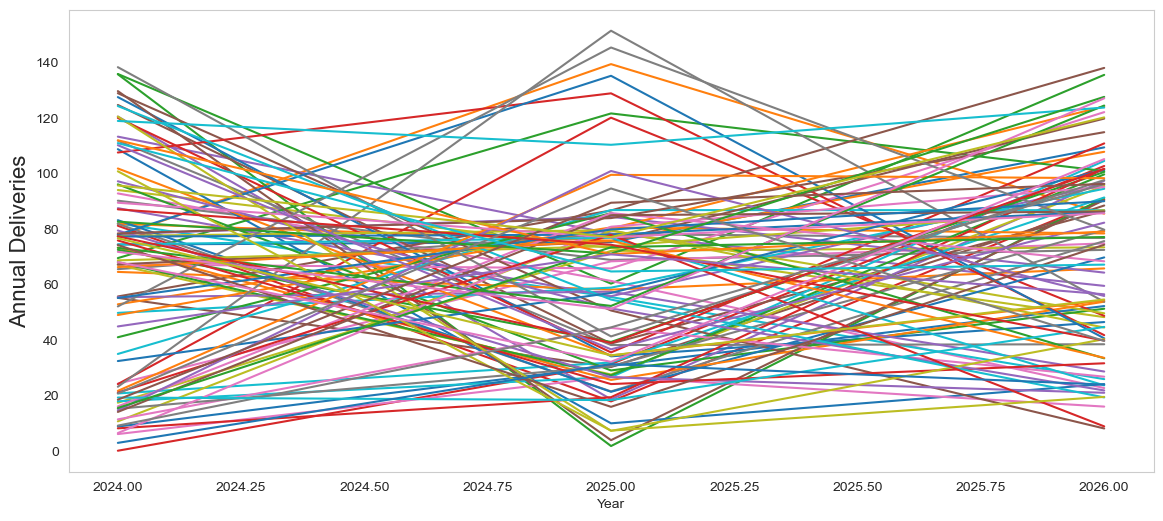

In [4]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_pumping  = datDaily['wonderful_BLR_pumping'] + datDaily['wonderful_LHL_pumping'] + datDaily['wonderful_BDM_pumping']
    
    yearly_sum = annual_pumping.resample('AS-OCT').sum()
    data_dict[f'Trace {i}'] = yearly_sum.values

data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

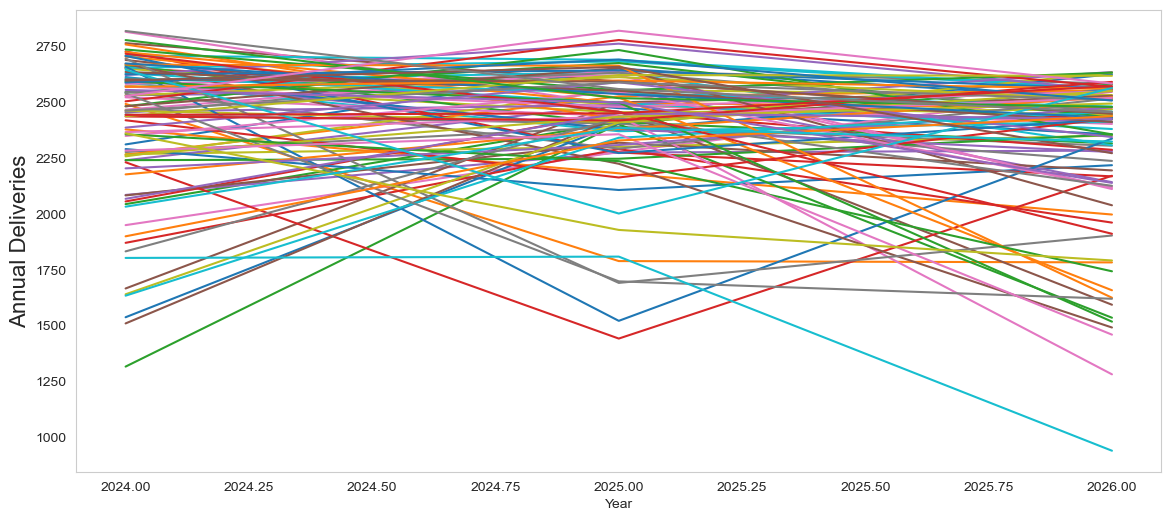

In [5]:
output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    datDaily.index = pd.to_datetime(datDaily.index)  
    
    annual_deliveries = datDaily['delta_HRO_pump']
    # + datDaily['wonderful_LHL_tableA_delivery'] + datDaily['wonderful_BDM_tableA_delivery']
    
    yearly_sum = annual_deliveries.resample('AS-OCT').sum()
    data_dict[f'Trace {i}'] = yearly_sum.values

data_dict['Year'] = yearly_sum.index.year 
df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))

for key in df.columns:
    if key != 'Year':
        ax.plot(df['Year'], df[key], label=key, alpha=1)

ax.set_xlabel('Year')
ax.set_ylabel('Annual Deliveries', fontsize=16)
# ax.legend()
ax.grid(False)
plt.show()

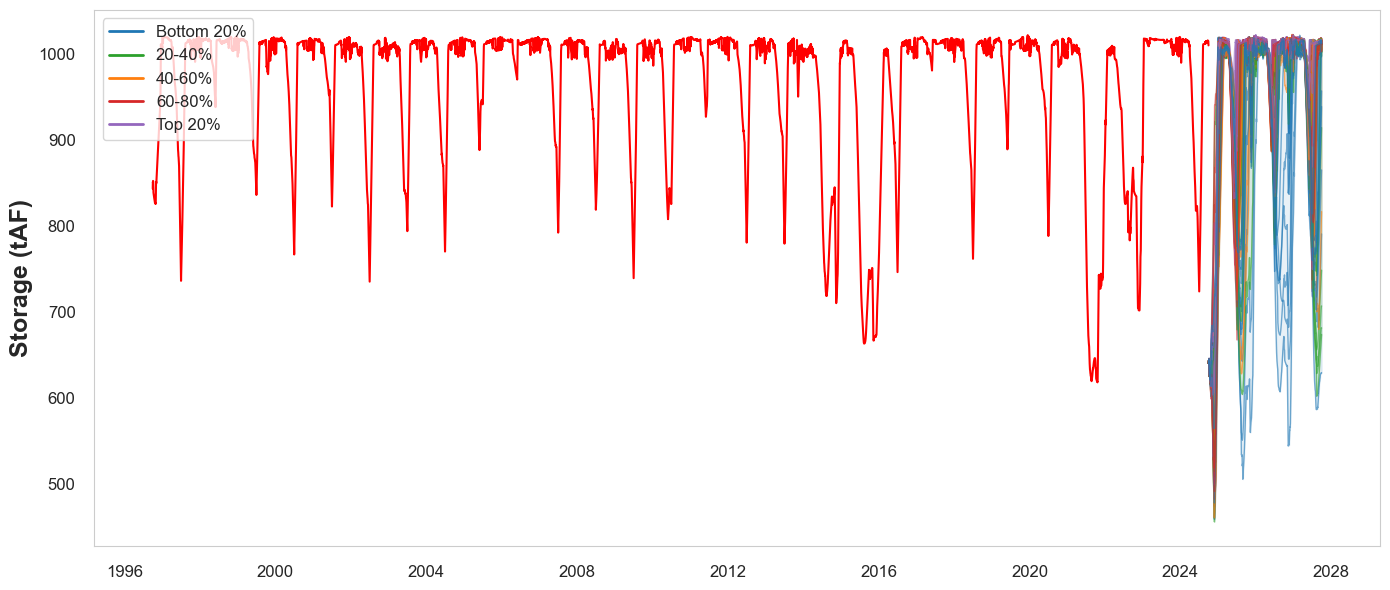

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.lines import Line2D


output_folder = "results/"
data_dict = {}

for i in range(1, 101):
    output_file = os.path.join(output_folder, str(i), 'results.hdf5')
    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    shasta_R_to_delta = datDaily['sanluisstate_S']
    data_dict[f'Trace {i}'] = shasta_R_to_delta


df = pd.DataFrame(data_dict)

fig, ax = plt.subplots(figsize=(14, 6))
trace_medians = df.median()

# Quintiles: 1 (Bottom 20%), 2 (20-40%), 3 (40-60%), 4 (60-80%), 5 (Top 20%)
quintiles = pd.qcut(trace_medians, 5, labels=[1, 2, 3, 4, 5])  # Labels 1 to 5

color_palette = {
    1: '#1f77b4',  # Blue - Bottom 20%
    2: '#2ca02c',  # Green - 20-40%
    3: '#ff7f0e',  # Orange - 40-60%
    4: '#d62728',  # Red - 60-80%
    5: '#9467bd'   # Purple - Top 20%
}

for trace, quintile in zip(data_dict.keys(), quintiles):
    ax.plot(df.index, data_dict[trace], color=color_palette[quintile], alpha=0.6,  linewidth=1)

for q in sorted(color_palette.keys()):
    # Select traces in the current quintile
    quintile_traces = df.columns[quintiles == q]
    quintile_data = df[quintile_traces]
    
    lower = quintile_data.min(axis=1)
    upper = quintile_data.max(axis=1)
  
    ax.fill_between(df.index, lower, upper, color=color_palette[q],  alpha=0.1, label=f'Quintile {q}' if q == 1 else "")  # Label only once to avoid duplicates

legend_elements = [
    Line2D([0], [0], color=color_palette[1], lw=2, label='Bottom 20%'),
    Line2D([0], [0], color=color_palette[2], lw=2, label='20-40%'),
    Line2D([0], [0], color=color_palette[3], lw=2, label='40-60%'),
    Line2D([0], [0], color=color_palette[4], lw=2, label='60-80%'),
    Line2D([0], [0], color=color_palette[5], lw=2, label='Top 20%')
]

handles = legend_elements 
# + shaded_elements
labels = [handle.get_label() for handle in handles]

unique_labels = {}
for handle in handles:
    if handle.get_label() not in unique_labels:
        unique_labels[handle.get_label()] = handle

output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
datDaily_val = get_results_sensitivity_number_outside_model(output_file, '')
ax.plot(datDaily_val['sanluisstate_S'], label = 'output', color = 'red') #

ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12, loc='upper left')

# ax.set_title('Comparison of Shasta Reservoir Storage (shasta_S) for 100 Traces', 
#              fontsize=18, fontweight='bold')
# ax.set_xlabel('Time', fontsize=14, fontweight='bold')
ax.set_ylabel('Storage (tAF)', fontsize=18, fontweight='bold')

ax.tick_params(axis='x', labelsize=12, pad=10, width=1)
ax.tick_params(axis='y', labelsize=12, pad=10, width=1)

ax.grid(False)

plt.tight_layout()
plt.show()

In [7]:
for x in datDaily.keys():
    print(x)

shasta_S
shasta_R
shasta_R_to_delta
shasta_available_storage
shasta_outflow_release
shasta_days_til_full
shasta_Q
shasta_SNPK
shasta_downstream
shasta_fnf
oroville_S
oroville_R
oroville_R_to_delta
oroville_available_storage
oroville_outflow_release
oroville_days_til_full
oroville_Q
oroville_SNPK
oroville_downstream
oroville_fnf
yuba_S
yuba_R
yuba_R_to_delta
yuba_available_storage
yuba_outflow_release
yuba_days_til_full
yuba_Q
yuba_SNPK
yuba_downstream
yuba_fnf
folsom_S
folsom_R
folsom_R_to_delta
folsom_available_storage
folsom_outflow_release
folsom_days_til_full
folsom_Q
folsom_SNPK
folsom_fnf
newmelones_S
newmelones_R
newmelones_R_to_delta
newmelones_Q
newmelones_SNPK
newmelones_downstream
newmelones_fnf
donpedro_S
donpedro_R
donpedro_R_to_delta
donpedro_Q
donpedro_SNPK
donpedro_downstream
donpedro_fnf
exchequer_S
exchequer_R
exchequer_R_to_delta
exchequer_Q
exchequer_SNPK
exchequer_downstream
exchequer_fnf
sanluisstate_S
sanluisstate_days_til_full
sanluisstate_contract_flooded
sanlu

In [8]:
datDaily[['wonderful_BLR_pumping','wonderful_LHL_pumping','wonderful_BDM_pumping']].head()

,wonderful_BLR_pumping,wonderful_LHL_pumping,wonderful_BDM_pumping
2024-10-01,0.0,0.0,0.0
2024-10-02,0.0,0.0,0.0
2024-10-03,0.0,0.0,0.0
2024-10-04,0.0,0.0,0.0
2024-10-05,0.0,0.0,0.0


In [9]:
all_adjusted_water_demand = []
all_annual_delta_exports = []
all_adjusted_shortfall = []
all_annual_cost = []

for i in range(1, 101):
    scenario_number = i
    input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    # Initialize total acreage for each crop
    total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
    total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0
    
    # Initialize cost and revenue from agricultural production
    # Immature pistachios (by year of immaturity)
    cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
    revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
    immature_acres_pistachio = np.zeros(6)
    
    # Mature pistachios
    mature_operating_costs_pistachio = 3210
    mature_revenues_pistachio = 5997
    
    # Immature almonds
    cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
    revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
    immature_acres_almond = np.ones(5) * total_acres_almond / 25.0
    
    # Mature almonds
    mature_operating_costs_almond = 3987
    mature_revenues_almond = 7500
    
    # Almonds stop being productive after 25 years
    acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0
    
    # Resample and aggregate relevant columns
    # Assuming you want to aggregate across all relevant water users
    annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()
    
    # Initialize aggregators
    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
        # Ensure the required columns exist
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
  
        # Resample each column
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
    # Calculate total water demand
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(len(total_water_demand))
    adjusted_shortfall = np.zeros(len(total_water_demand))
    annual_cost = np.zeros(len(total_water_demand))
    
    for year_sim in range(len(total_water_demand)):
        # we assume that any fallowed orchards are immediately replanted
         # but immature acres use 25% of the water that mature acres use
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
        pct_fallowed = adjusted_shortfall[year_sim] / adjusted_water_demand[year_sim] if adjusted_water_demand[year_sim] > 0 else 0.0
        fallowed_almonds = pct_fallowed * total_acres_almond
        fallowed_pistachios = pct_fallowed * total_acres_pistachio
        
        # cost of fallowing is equal to (revenue - cost) for mature orchards
        # minus (revenue - cost) for immature orchards
        # since orchards take 6 years to mature, costs accrue across 6 years
        # revenue - cost for immature orchards changes based on the age
        cost_pistachio = 0.0
        cost_almond = 0.0
        for year_loss in range(len(cost_per_acre_pistachio)):
            discounted_factor = 1.05 ** year_loss
            revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                            mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
            cost = (fallowed_pistachios * revenue_loss) / discounted_factor
            annual_cost[year_sim] += cost
            cost_pistachio += cost
            # print(f"Scenario {scenario_number} - Year {year_sim}: Pistachio Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")

        # cost of fallowing is the same for almonds, except
        # we need to account for the fact that all 25 year old
        # almond trees are fallowed regardless of irrigation availability         
        total_fallowed_almonds = 0.0
        for age_year in reversed(range(25)):
          
            age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds) # amount of acreage selected for fallowing from the current age group does not exceed the available acreage
                      
            for year_loss in range(len(cost_per_acre_almond)):
                expected_age = age_year + year_loss
                discounted_factor = 1.05 ** year_loss
                if expected_age < 25:
                    revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] - mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
                else:
                    # Compare with immature tree costs and revenues
                    adjusted_year = expected_age - 25
                    revenue_loss = (revenue_per_acre_almond[adjusted_year] + cost_per_acre_almond[year_loss] - cost_per_acre_almond[adjusted_year] - revenue_per_acre_almond[year_loss])
                cost = (age_fallowed * revenue_loss) / discounted_factor
                annual_cost[year_sim] += cost
                cost_almond += cost
                # print(f"Scenario {scenario_number} - Year {year_sim}: Almond Age {age_year}, Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")
          
            acres_by_year_almond[age_year] -= age_fallowed
            fallowed_almonds -= age_fallowed
            total_fallowed_almonds += age_fallowed
       
        print(f"Scenario {scenario_number} - Year {year_sim}: Total Pistachio Cost ($MM): {cost_pistachio/1000000:.2f}, Total Almond Cost($MM): {cost_almond/1000000:.2f}, Annual Cost($MM): {annual_cost[year_sim]/1000000:.2f}")
        print(f"Scenario {scenario_number} - Year {year_sim}: Fallowed Pistachios: {fallowed_pistachios:.2f}, Fallowed Almonds: {total_fallowed_almonds:.2f}, ")
        
        # Update pistachio acres
        total_acres_pistachio -= fallowed_pistachios
        total_acres_pistachio += immature_acres_pistachio[-1]
        
        # Age immature pistachios
        for immature_yr in range(5, 0, -1):
            immature_acres_pistachio[immature_yr] = immature_acres_pistachio[immature_yr - 1] * 1.0
        immature_acres_pistachio[0] = fallowed_pistachios * 1.0 # any fallowed pistchios are immediately replanted (as immature pistachios)

        total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
        for age_year in range(24, 0, -1):
            acres_by_year_almond[age_year] = acres_by_year_almond[age_year - 1] * 1.0
        acres_by_year_almond[0] = immature_acres_almond[4] * 1.0  # newly mature almonds from the oldest group of immature almonds
        
        for immature_yr in range(4, 0, -1):
            immature_acres_almond[immature_yr] = immature_acres_almond[immature_yr - 1] * 1.0
        immature_acres_almond[0] = total_fallowed_almonds * 1.0
    
    start_year = None
    end_year = None

    if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
        start_year = annual_delta_exports.index.year.min()
        end_year = annual_delta_exports.index.year.max()
    else:
        start_year = 1997
        end_year = 2016  
    
    years = np.arange(start_year, end_year + 1)

    # Store results in a DataFrame for each scenario
    scenario_adjusted_water_demand = pd.DataFrame(adjusted_water_demand, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_delta_exports = pd.DataFrame(annual_delta_exports.values, index=years, columns=[f'Scenario_{i}'])
    scenario_adjusted_shortfall = pd.DataFrame(adjusted_shortfall, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_cost = pd.DataFrame(annual_cost, index=years, columns=[f'Scenario_{i}'])

    all_adjusted_water_demand.append(scenario_adjusted_water_demand)
    all_annual_delta_exports.append(scenario_annual_delta_exports)
    all_adjusted_shortfall.append(scenario_adjusted_shortfall)
    all_annual_cost.append(scenario_annual_cost)

df_adjusted_water_demand = pd.concat(all_adjusted_water_demand, axis=1)
df_annual_delta_exports = pd.concat(all_annual_delta_exports, axis=1)
df_adjusted_shortfall = pd.concat(all_adjusted_shortfall, axis=1)
df_annual_cost = pd.concat(all_annual_cost, axis=1)



Scenario 1 - Year 0: Total Pistachio Cost ($MM): 202.07, Total Almond Cost($MM): 145.16, Annual Cost($MM): 347.23
Scenario 1 - Year 0: Fallowed Pistachios: 8995.35, Fallowed Almonds: 8342.78, 
Scenario 1 - Year 1: Total Pistachio Cost ($MM): 69.49, Total Almond Cost($MM): 105.11, Annual Cost($MM): 174.60
Scenario 1 - Year 1: Fallowed Pistachios: 3093.40, Fallowed Almonds: 3715.98, 
Scenario 1 - Year 2: Total Pistachio Cost ($MM): 98.06, Total Almond Cost($MM): 165.09, Annual Cost($MM): 263.15
Scenario 1 - Year 2: Fallowed Pistachios: 4365.20, Fallowed Almonds: 5836.26, 
Scenario 2 - Year 0: Total Pistachio Cost ($MM): 210.68, Total Almond Cost($MM): 155.21, Annual Cost($MM): 365.89
Scenario 2 - Year 0: Fallowed Pistachios: 9378.46, Fallowed Almonds: 8698.10, 
Scenario 2 - Year 1: Total Pistachio Cost ($MM): 239.36, Total Almond Cost($MM): 366.67, Annual Cost($MM): 606.02
Scenario 2 - Year 1: Fallowed Pistachios: 10655.12, Fallowed Almonds: 12962.56, 
Scenario 2 - Year 2: Total Pistachi

In [10]:
df_annual_cost

,Scenario_1,Scenario_2,Scenario_3,Scenario_4,Scenario_5,Scenario_6,Scenario_7,Scenario_8,Scenario_9,Scenario_10,...,Scenario_91,Scenario_92,Scenario_93,Scenario_94,Scenario_95,Scenario_96,Scenario_97,Scenario_98,Scenario_99,Scenario_100
2024,3.472294e+08,3.658861e+08,7.397842e+08,3.925158e+08,6.248801e+08,2.115260e+08,5.176128e+08,4.586115e+08,4.918575e+08,3.885876e+08,...,0.000000e+00,6.328673e+08,1.840861e+06,4.412334e+08,1.684292e+08,1.865911e+07,3.031928e+08,2.780010e+07,5.090553e+08,6.186983e+08
2025,1.746030e+08,6.060246e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.646044e+08,0.000000e+00,4.452129e+08,1.755907e+07,3.964551e+08,5.330716e+08,0.000000e+00,5.573162e+08,0.000000e+00,0.000000e+00
2026,2.631482e+08,0.000000e+00,5.143144e+07,3.256042e+08,0.000000e+00,4.171410e+08,0.000000e+00,1.202971e+08,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,3.816776e+07,0.000000e+00,0.000000e+00,1.187006e+08,4.723564e+08,0.000000e+00,2.546170e+08,0.000000e+00



Defined Segments:
Bottom 5%: 0.00 ($MM)
5% - 10%: 0.21 ($MM)
10% - 20%: 27.53 ($MM)
20% - 80%: 511.79 ($MM)
80% - 90%: 134.77 ($MM)
90% - 95%: 59.73 ($MM)
95% - 100%: 103.61 ($MM)


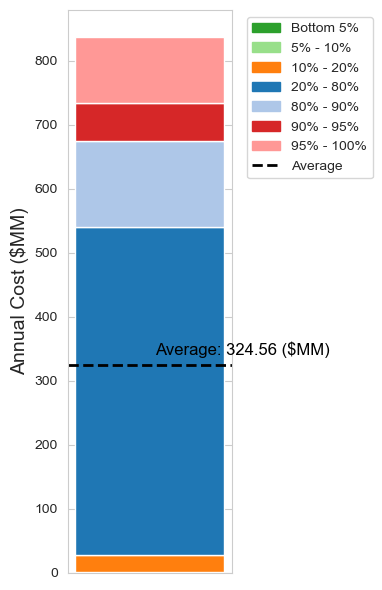

In [11]:
data = df_annual_cost.iloc[0, :]/1000000

average_cost = data.mean()

desired_percentiles = [5, 10, 20, 80, 90, 95]  # Percentiles in percentages

percentile_values = data.quantile([p/100 for p in desired_percentiles]).values
percentile_values_sorted = sorted(percentile_values)

p5, p10, p20, p80, p90, p95 = percentile_values_sorted

segments = {
    'Bottom 5%': p5 - data.min(),'5% - 10%': p10 - p5,'10% - 20%': p20 - p10, '20% - 80%': p80 - p20, '80% - 90%': p90 - p80, '90% - 95%': p95 - p90, '95% - 100%': data.max() - p95  }

segments = {k: max(v, 0) for k, v in segments.items()}

print("\nDefined Segments:")
for segment, height in segments.items():
    print(f"{segment}: {height:.2f} ($MM)")


colors = {'Bottom 5%': '#2ca02c',      # Green
    '5% - 10%': '#98df8a',       # Light Green
    '10% - 20%': '#ff7f0e',      # Orange
    '20% - 80%': '#1f77b4',      # Blue
    '80% - 90%': '#aec7e8',      # Light Blue
    '90% - 95%': '#d62728',      # Red
    '95% - 100%': '#ff9896'      # Light Red
}


fig, ax = plt.subplots(figsize=(4, 6))
bottom = 0

for segment, height in segments.items():
    ax.bar('Average Annual Cost', height, bottom=bottom, color=colors.get(segment, 'grey'), label=segment)
    bottom += height


ax.axhline(y=average_cost, color='black', linestyle='--', linewidth=2, label=f'Average: {average_cost:.2f} ($MM)')

ax.set_ylabel('Annual Cost ($MM)', fontsize=14)
# ax.set_title('Average Annual Cost with Percentile Indications', fontsize=16)

from matplotlib.patches import Patch
legend_patches = [Patch(color=colors[seg], label=seg) for seg in segments.keys()]
legend_patches.append(plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Average'))

ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

ax.text(0.5, average_cost + (max(segments.values()) * 0.02), f'Average: {average_cost:.2f} ($MM)', 
        color='black', ha='center', va='bottom', fontsize=12)

ax.set_xticks([])

plt.tight_layout()
plt.show()


In [12]:
water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)
price_dates = ['2025-06-30']#'2026-06-30', '2027-06-30'
price_dates = pd.to_datetime(price_dates)
water_price_data.loc[price_dates, f"Scenario {1}"].values
# water_price_data
water_price_data.loc[price_dates].mean()


Scenario 1      377.430036
Scenario 2      311.553824
Scenario 3      448.285228
Scenario 4      376.761730
Scenario 5      490.249936
                   ...    
Scenario 96     277.882697
Scenario 97     333.212728
Scenario 98     283.266844
Scenario 99     444.247540
Scenario 100    517.182539
Length: 100, dtype: float64

In [13]:
# alternative 1: purchase water at spot market (water price is water index value end of june)
# Water purchase price per acre-feet for years 1 to 3
water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)
price_dates = ['2025-06-30', '2026-06-30', '2027-06-30']
price_dates = pd.to_datetime(price_dates)

all_adjusted_water_demand = []
all_annual_delta_exports = []
all_adjusted_shortfall = []
all_annual_cost = []

for i in range(1, 101):
    scenario_number = i
    input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    # Initialize total acreage for each crop
    total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
    total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0
    
    # Initialize cost and revenue from agricultural production
    # Immature pistachios (by year of immaturity)
    cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
    revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
    immature_acres_pistachio = np.zeros(6)
    
    # Mature pistachios
    mature_operating_costs_pistachio = 3210
    mature_revenues_pistachio = 5997
    
    # Immature almonds
    cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
    revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
    immature_acres_almond = np.ones(5) * total_acres_almond / 25.0
    
    # Mature almonds
    mature_operating_costs_almond = 3987
    mature_revenues_almond = 7500
    
    # Almonds stop being productive after 25 years
    acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0
    
    # Get water prices for the current scenario
    scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values

    annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()
    
    # Initialize aggregators
    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
        # Ensure the required columns exist
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
                       
        # Resample each column
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
    # Calculate total water demand
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(len(total_water_demand))
    adjusted_shortfall = np.zeros(len(total_water_demand))
    annual_cost = np.zeros(len(total_water_demand))
    
    for year_sim in range(len(total_water_demand)):
   
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)

        purchase_cost = adjusted_shortfall[year_sim] * scenario_prices[year_sim]  # purchase cost for water shortfall
        annual_cost[year_sim] += purchase_cost
        print(f"Scenario {scenario_number} - Year {year_sim}: Shortfall: {adjusted_shortfall[year_sim]:.2f} AF,unit price:{scenario_prices[year_sim]:.2f}, Purchase Cost: ${purchase_cost:.2f}")

        fallowed_almonds = 0
        fallowed_pistachios = 0
        
        # cost of fallowing for pistachios is 0 since fallowed_pistachios = 0
        cost_pistachio = 0.0
        cost_almond = 0.0
        for year_loss in range(len(cost_per_acre_pistachio)):
            discounted_factor = 1.05 ** year_loss
            revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                            mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
            cost = (fallowed_pistachios * revenue_loss) / discounted_factor
            annual_cost[year_sim] += cost
            cost_pistachio += cost
            # print(f"Scenario {scenario_number} - Year {year_sim}: Pistachio Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")

        # cost of fallowing for almond is 0 since fallowed_almonds = 0       
        total_fallowed_almonds = 0.0
        for age_year in reversed(range(25)):
          
            age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds)   ### here instead of min of fallowed_almonds,use the total acres of almond tree
                      
            for year_loss in range(len(cost_per_acre_almond)):
                expected_age = age_year + year_loss
                discounted_factor = 1.05 ** year_loss
                if expected_age < 25:
                    revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] - mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
                else:
                    # Compare with immature tree costs and revenues
                    adjusted_year = expected_age - 25
                    revenue_loss = (revenue_per_acre_almond[adjusted_year] + cost_per_acre_almond[year_loss] - cost_per_acre_almond[adjusted_year] - revenue_per_acre_almond[year_loss])
                cost = (age_fallowed * revenue_loss) / discounted_factor
                annual_cost[year_sim] += cost
                cost_almond += cost
                # print(f"Scenario {scenario_number} - Year {year_sim}: Almond Age {age_year}, Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")
          
            acres_by_year_almond[age_year] -= age_fallowed
            fallowed_almonds -= age_fallowed
            total_fallowed_almonds += age_fallowed
       
        print(f"Scenario {scenario_number} - Year {year_sim}: Total Pistachio Cost ($MM): {cost_pistachio:.2f}, Total Almond Cost($MM): {cost_almond:.2f}, Annual Cost($MM): {annual_cost[year_sim]:.2f}")
        print(f"Scenario {scenario_number} - Year {year_sim}: Fallowed Pistachios: {fallowed_pistachios:.2f}, Fallowed Almonds: {cost_almond:.2f}, ")
        
        # Update pistachio acres
        total_acres_pistachio -= fallowed_pistachios
        total_acres_pistachio += immature_acres_pistachio[-1]
        
        # Age immature pistachios
        for immature_yr in range(5, 0, -1):
            immature_acres_pistachio[immature_yr] = immature_acres_pistachio[immature_yr - 1] * 1.0
        immature_acres_pistachio[0] = fallowed_pistachios * 1.0 # any fallowed pistchios are immediately replanted (as immature pistachios)

        total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
        for age_year in range(24, 0, -1):
            acres_by_year_almond[age_year] = acres_by_year_almond[age_year - 1] * 1.0
        acres_by_year_almond[0] = immature_acres_almond[4] * 1.0  # newly mature almonds from the oldest group of immature almonds
        
        for immature_yr in range(4, 0, -1):
            immature_acres_almond[immature_yr] = immature_acres_almond[immature_yr - 1] * 1.0
        immature_acres_almond[0] = total_fallowed_almonds * 1.0
    
    start_year = None
    end_year = None

    if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
        start_year = annual_delta_exports.index.year.min()
        end_year = annual_delta_exports.index.year.max()
    else:
        start_year = 1997
        end_year = 2016  
    
    years = np.arange(start_year, end_year + 1)

    # Store results in a DataFrame for each scenario
    scenario_adjusted_water_demand = pd.DataFrame(adjusted_water_demand, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_delta_exports = pd.DataFrame(annual_delta_exports.values, index=years, columns=[f'Scenario_{i}'])
    scenario_adjusted_shortfall = pd.DataFrame(adjusted_shortfall, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_cost = pd.DataFrame(annual_cost, index=years, columns=[f'Scenario_{i}'])

    all_adjusted_water_demand.append(scenario_adjusted_water_demand)
    all_annual_delta_exports.append(scenario_annual_delta_exports)
    all_adjusted_shortfall.append(scenario_adjusted_shortfall)
    all_annual_cost.append(scenario_annual_cost)

df_adjusted_water_demand_purchased = pd.concat(all_adjusted_water_demand, axis=1)
df_annual_delta_exports_purchased = pd.concat(all_annual_delta_exports, axis=1)
df_adjusted_shortfall_purchased = pd.concat(all_adjusted_shortfall, axis=1)
df_annual_cost_purchased = pd.concat(all_annual_cost, axis=1)



Scenario 1 - Year 0: Shortfall: 55.43 AF,unit price:377.43, Purchase Cost: $20921.59
Scenario 1 - Year 0: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 20921.59
Scenario 1 - Year 0: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 1 - Year 1: Shortfall: 59.00 AF,unit price:399.43, Purchase Cost: $23567.31
Scenario 1 - Year 1: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 23567.31
Scenario 1 - Year 1: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 1 - Year 2: Shortfall: 91.47 AF,unit price:568.74, Purchase Cost: $52024.46
Scenario 1 - Year 2: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 52024.46
Scenario 1 - Year 2: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 2 - Year 0: Shortfall: 58.24 AF,unit price:311.55, Purchase Cost: $18144.37
Scenario 2 - Year 0: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 18

In [14]:
##Estimation of future contract price
##based on weighted average of water shortfall for all scenarios
water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)

price_dates = ['2025-06-30', '2026-06-30', '2027-06-30']
price_dates = pd.to_datetime(price_dates)

acre_feet_per_contract = 10  # One contract represents 10 acre-feet
fees = 2.25*2  # Fees for futures and futures options are $2.251 per contract, plus exchange and regulatory fees (assumed to be $2.25 per contract)

total_shortfall_by_year = np.zeros(3)
total_weighted_cost_by_year = np.zeros(3)

for i in range(1, 101):
    scenario_number = i
    input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values # Get water prices for the current scenario

    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
 
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
       
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
   
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(3)
    adjusted_shortfall = np.zeros(3)
      
    for year_sim in range(3):
   
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)
       
    total_shortfall_by_year += adjusted_shortfall
    total_weighted_cost_by_year += adjusted_shortfall * scenario_prices

    
weighted_average_prices = total_weighted_cost_by_year / total_shortfall_by_year
for year_idx, price in enumerate(weighted_average_prices):
    print(f"Year {2025 + year_idx}: Weighted Average Contract Price = ${price:.2f} per acre-foot")

Year 2025: Weighted Average Contract Price = $433.09 per acre-foot
Year 2026: Weighted Average Contract Price = $419.48 per acre-foot
Year 2027: Weighted Average Contract Price = $441.67 per acre-foot


In [15]:
#alternative 2: purchase water at futures market (water price is wieghted avaregae index value)
acre_feet_per_contract = 10  # One contract represents 10 acre-feet
fees = 2.25*2  # Fees for futures and futures options are $2.251 per contract, plus exchange and regulatory fees (assumed to be $2.25 per contract)

all_adjusted_water_demand = []
all_annual_delta_exports = []
all_adjusted_shortfall = []
all_annual_cost = []

for i in range(1, 101):
    scenario_number = i
    # input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
    # Initialize total acreage for each crop
    total_acres_almond = (21.385 + 7.175 + 8.042) * 1000.0
    total_acres_pistachio = (12.060 + 13.685 + 13.72) * 1000.0
    
    # Initialize cost and revenue from agricultural production
    # Immature pistachios (by year of immaturity)
    cost_per_acre_pistachio = [3469, 822, 968, 1071, 1394, 1794]
    revenue_per_acre_pistachio = [0, 0, 0, 0, 0, 1272]
    immature_acres_pistachio = np.zeros(6)
    
    # Mature pistachios
    mature_operating_costs_pistachio = 3210
    mature_revenues_pistachio = 5997
    
    # Immature almonds
    cost_per_acre_almond = [6565, 1462, 2358, 3171, 3691]
    revenue_per_acre_almond = [0, 0, 600, 1200, 2400]
    immature_acres_almond = np.ones(5) * total_acres_almond / 25.0
    
    # Mature almonds
    mature_operating_costs_almond = 3987
    mature_revenues_almond = 7500
    
    # Almonds stop being productive after 25 years
    acres_by_year_almond = np.ones(25) * total_acres_almond / 25.0
    
    # Get water prices for the current scenario
    # scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values

    annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()
    
    # Initialize aggregators
    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
        # Ensure the required columns exist
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
                       
        # Resample each column
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
    # Calculate total water demand
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(len(total_water_demand))
    adjusted_shortfall = np.zeros(len(total_water_demand))
    annual_cost = np.zeros(len(total_water_demand))
    
    for year_sim in range(len(total_water_demand)):
   
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)

        required_contracts = int((adjusted_shortfall[year_sim] + acre_feet_per_contract - 1) // acre_feet_per_contract)  # Ceiling division for full coverage
        shortfall_coverage = required_contracts * acre_feet_per_contract  # Total acre-feet covered by the contracts
        # Calculate purchase cost for the contracts
        purchase_cost = shortfall_coverage * weighted_average_prices[year_sim]  # Full coverage purchase cost
        fee_cost = required_contracts * fees               # Total fees for the contracts

        annual_cost[year_sim] += purchase_cost + fee_cost

        print(f"Scenario {scenario_number} - Year {year_sim}: Shortfall: {adjusted_shortfall[year_sim]:.2f} AF, required_contracts:{required_contracts}, future price:{weighted_average_prices[year_sim]}, Purchase Cost: ${annual_cost[year_sim]:.2f}")

        fallowed_almonds = 0
        fallowed_pistachios = 0
        
        # cost of fallowing for pistachios is 0 since fallowed_pistachios = 0
        cost_pistachio = 0.0
        cost_almond = 0.0
        for year_loss in range(len(cost_per_acre_pistachio)):
            discounted_factor = 1.05 ** year_loss
            revenue_loss = (mature_revenues_pistachio + cost_per_acre_pistachio[year_loss] -
                            mature_operating_costs_pistachio - revenue_per_acre_pistachio[year_loss])
            cost = (fallowed_pistachios * revenue_loss) / discounted_factor
            annual_cost[year_sim] += cost
            cost_pistachio += cost
            # print(f"Scenario {scenario_number} - Year {year_sim}: Pistachio Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")

        # cost of fallowing for almond is 0 since fallowed_almonds = 0       
        total_fallowed_almonds = 0.0
        for age_year in reversed(range(25)):
          
            age_fallowed = min(acres_by_year_almond[age_year], fallowed_almonds)   ### here instead of min of fallowed_almonds,use the total acres of almond tree
                      
            for year_loss in range(len(cost_per_acre_almond)):
                expected_age = age_year + year_loss
                discounted_factor = 1.05 ** year_loss
                if expected_age < 25:
                    revenue_loss = (mature_revenues_almond + cost_per_acre_almond[year_loss] - mature_operating_costs_almond - revenue_per_acre_almond[year_loss])
                else:
                    # Compare with immature tree costs and revenues
                    adjusted_year = expected_age - 25
                    revenue_loss = (revenue_per_acre_almond[adjusted_year] + cost_per_acre_almond[year_loss] - cost_per_acre_almond[adjusted_year] - revenue_per_acre_almond[year_loss])
                cost = (age_fallowed * revenue_loss) / discounted_factor
                annual_cost[year_sim] += cost
                cost_almond += cost
                # print(f"Scenario {scenario_number} - Year {year_sim}: Almond Age {age_year}, Year Loss {year_loss}, Revenue Loss: {revenue_loss:.2f}, Cost: {cost:.2f}")
          
            acres_by_year_almond[age_year] -= age_fallowed
            fallowed_almonds -= age_fallowed
            total_fallowed_almonds += age_fallowed
       
        print(f"Scenario {scenario_number} - Year {year_sim}: Total Pistachio Cost ($MM): {cost_pistachio:.2f}, Total Almond Cost($MM): {cost_almond:.2f}, Annual Cost($MM): {annual_cost[year_sim]:.2f}")
        print(f"Scenario {scenario_number} - Year {year_sim}: Fallowed Pistachios: {fallowed_pistachios:.2f}, Fallowed Almonds: {cost_almond:.2f}, ")
        
        # Update pistachio acres
        total_acres_pistachio -= fallowed_pistachios
        total_acres_pistachio += immature_acres_pistachio[-1]
        
        # Age immature pistachios
        for immature_yr in range(5, 0, -1):
            immature_acres_pistachio[immature_yr] = immature_acres_pistachio[immature_yr - 1] * 1.0
        immature_acres_pistachio[0] = fallowed_pistachios * 1.0 # any fallowed pistchios are immediately replanted (as immature pistachios)

        total_fallowed_almonds += acres_by_year_almond[-1]  # Fallow 25-year-old trees
        for age_year in range(24, 0, -1):
            acres_by_year_almond[age_year] = acres_by_year_almond[age_year - 1] * 1.0
        acres_by_year_almond[0] = immature_acres_almond[4] * 1.0  # newly mature almonds from the oldest group of immature almonds
        
        for immature_yr in range(4, 0, -1):
            immature_acres_almond[immature_yr] = immature_acres_almond[immature_yr - 1] * 1.0
        immature_acres_almond[0] = total_fallowed_almonds * 1.0
    
    start_year = None
    end_year = None

    if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
        start_year = annual_delta_exports.index.year.min()
        end_year = annual_delta_exports.index.year.max()
    else:
        start_year = 1997
        end_year = 2016  
    
    years = np.arange(start_year, end_year + 1)

    # Store results in a DataFrame for each scenario
    scenario_adjusted_water_demand = pd.DataFrame(adjusted_water_demand, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_delta_exports = pd.DataFrame(annual_delta_exports.values, index=years, columns=[f'Scenario_{i}'])
    scenario_adjusted_shortfall = pd.DataFrame(adjusted_shortfall, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_cost = pd.DataFrame(annual_cost, index=years, columns=[f'Scenario_{i}'])

    all_adjusted_water_demand.append(scenario_adjusted_water_demand)
    all_annual_delta_exports.append(scenario_annual_delta_exports)
    all_adjusted_shortfall.append(scenario_adjusted_shortfall)
    all_annual_cost.append(scenario_annual_cost)

df_adjusted_water_demand_contract = pd.concat(all_adjusted_water_demand, axis=1)
df_annual_delta_exports_contract = pd.concat(all_annual_delta_exports, axis=1)
df_adjusted_shortfall_contract = pd.concat(all_adjusted_shortfall, axis=1)
df_annual_cost_contract= pd.concat(all_annual_cost, axis=1)
print(df_annual_cost_contract.iloc[0, :].mean())




Scenario 1 - Year 0: Shortfall: 55.43 AF, required_contracts:6, future price:433.08827405076045, Purchase Cost: $26012.30
Scenario 1 - Year 0: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 26012.30
Scenario 1 - Year 0: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 1 - Year 1: Shortfall: 59.00 AF, required_contracts:6, future price:419.4820444262018, Purchase Cost: $25195.92
Scenario 1 - Year 1: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 25195.92
Scenario 1 - Year 1: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 1 - Year 2: Shortfall: 91.47 AF, required_contracts:10, future price:441.6711209278934, Purchase Cost: $44212.11
Scenario 1 - Year 2: Total Pistachio Cost ($MM): 0.00, Total Almond Cost($MM): 0.00, Annual Cost($MM): 44212.11
Scenario 1 - Year 2: Fallowed Pistachios: 0.00, Fallowed Almonds: 0.00, 
Scenario 2 - Year 0: Shortfall: 58.24 AF, required_contracts:6, future price:433

In [16]:
#alternative 3: hybrid approach (purchase water at spot market and futures market)
acre_feet_per_contract = 10  # One contract represents 10 acre-feet
fees = 2.25*2  # Fees for futures and futures options are $2.251 per contract, plus exchange and regulatory fees (assumed to be $2.25 per contract)

all_adjusted_water_demand = []
all_annual_delta_exports = []
all_adjusted_shortfall = []
all_annual_cost = []

for i in range(1, 101):
    scenario_number = i
    # input_filename = f"results/{i}/source_file.hdf5"
    output_folder = f"results/{i}/"
    output_file = output_folder + 'results.hdf5'

    datDaily = get_results_sensitivity_number_outside_model(output_file, '')
    validation = datDaily
    list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']
    
        # Get water prices for the current scenario
    scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values

    annual_delta_exports = validation['delta_HRO_pump'].resample('AS-OCT').sum()
    
    # Initialize aggregators
    annual_deliveries = 0
    annual_pumping = 0
    annual_exchanged = 0
    
    for wu in list_of_water_users:
        # Ensure the required columns exist
        delivery_col = f'{wu}_tableA_delivery'
        pumping_col = f'{wu}_pumping'
        exchanged_col = f'{wu}_exchanged_GW'
                       
        # Resample each column
        deliveries = validation[delivery_col].resample('AS-OCT').max()
        pumping = validation[pumping_col].resample('AS-OCT').sum()
        exchanged = validation[exchanged_col].resample('AS-OCT').max()
        
        annual_deliveries += deliveries
        annual_pumping += pumping
        annual_exchanged += exchanged
    
    # Calculate total water demand
    total_water_demand = annual_deliveries + annual_pumping
    adjusted_water_demand = np.zeros(len(total_water_demand))
    adjusted_shortfall = np.zeros(len(total_water_demand))
    annual_cost = np.zeros(len(total_water_demand))
    
    for year_sim in range(len(total_water_demand)):
   
        immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
        adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
        adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)

        # required_contracts = int((adjusted_shortfall[year_sim] + acre_feet_per_contract - 1) // acre_feet_per_contract)  # Ceiling division for full coverage
        # shortfall_coverage = required_contracts * acre_feet_per_contract  # Total acre-feet covered by the contracts
        # # Calculate purchase cost for the contracts
        # purchase_cost = shortfall_coverage * weighted_average_prices[year_sim]  # Full coverage purchase cost
        # fee_cost = required_contracts * fees               # Total fees for the contracts

        half_shortfall = adjusted_shortfall[year_sim] / 2
        spot_cost = adjusted_shortfall[year_sim]*0.5 * scenario_prices[year_sim]

        required_contracts = int((adjusted_shortfall[year_sim]*0.5 + 10 - 1) // 10)
        futures_coverage = required_contracts * 10
        futures_cost = futures_coverage * weighted_average_prices[year_sim]
        fees = required_contracts * (2.25 * 2)  # Include contract fees
        purchase_cost = spot_cost + futures_cost + fees

        # Update the annual cost
        annual_cost[year_sim] += purchase_cost 

        print(f"Scenario {scenario_number} - Year {year_sim}: Shortfall: {adjusted_shortfall[year_sim]:.2f}, required_contracts:{required_contracts} spot price:{scenario_prices[year_sim]:.2f}, spot_cost:{spot_cost:.2f}, contract:{futures_cost:.2f}, Purchase Cost: ${purchase_cost:.2f}")

        

    # if isinstance(annual_delta_exports.index, pd.DatetimeIndex):
    #     start_year = annual_delta_exports.index.year.min()
    #     end_year = annual_delta_exports.index.year.max()
    # else:
    #     start_year = 1997
    #     end_year = 2016  
    
    # years = np.arange(start_year, end_year + 1)

    # Store results in a DataFrame for each scenario
    scenario_adjusted_water_demand = pd.DataFrame(adjusted_water_demand, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_delta_exports = pd.DataFrame(annual_delta_exports.values, index=years, columns=[f'Scenario_{i}'])
    scenario_adjusted_shortfall = pd.DataFrame(adjusted_shortfall, index=years, columns=[f'Scenario_{i}'])
    scenario_annual_cost = pd.DataFrame(annual_cost, index=years, columns=[f'Scenario_{i}'])

    all_adjusted_water_demand.append(scenario_adjusted_water_demand)
    all_annual_delta_exports.append(scenario_annual_delta_exports)
    all_adjusted_shortfall.append(scenario_adjusted_shortfall)
    all_annual_cost.append(scenario_annual_cost)

df_adjusted_water_demand_hybrid = pd.concat(all_adjusted_water_demand, axis=1)
df_annual_delta_exports_hybrid = pd.concat(all_annual_delta_exports, axis=1)
df_adjusted_shortfall_hybrid = pd.concat(all_adjusted_shortfall, axis=1)
df_annual_cost_hybrid= pd.concat(all_annual_cost, axis=1)



Scenario 1 - Year 0: Shortfall: 55.43, required_contracts:3 spot price:377.43, spot_cost:10460.80, contract:12992.65, Purchase Cost: $23466.94
Scenario 1 - Year 1: Shortfall: 59.00, required_contracts:3 spot price:399.43, spot_cost:11783.65, contract:12584.46, Purchase Cost: $24381.61
Scenario 1 - Year 2: Shortfall: 91.47, required_contracts:5 spot price:568.74, spot_cost:26012.23, contract:22083.56, Purchase Cost: $48118.29
Scenario 2 - Year 0: Shortfall: 58.24, required_contracts:3 spot price:311.55, spot_cost:9072.19, contract:12992.65, Purchase Cost: $22078.34
Scenario 2 - Year 1: Shortfall: 120.35, required_contracts:6 spot price:599.93, spot_cost:36101.89, contract:25168.92, Purchase Cost: $61297.81
Scenario 2 - Year 2: Shortfall: 66.34, required_contracts:4 spot price:634.81, spot_cost:21056.72, contract:17666.84, Purchase Cost: $38741.57
Scenario 3 - Year 0: Shortfall: 115.13, required_contracts:6 spot price:448.29, spot_cost:25806.60, contract:25985.30, Purchase Cost: $51818.9

In [17]:
df_annual_cost_hybrid.iloc[0, :].mean()

23207.85852846731

In [18]:
def calculate_annual_cost(strategy, water_price_data, weighted_average_prices, price_dates, scenarios=100):
    """
    Calculate annual costs for water purchasing strategies.
    
    Parameters:
        strategy (str): The water purchasing strategy ('spot', 'futures', 'hybrid').
        water_price_data (pd.DataFrame): DataFrame containing water price predictions.
        weighted_average_prices (list): Weighted average prices for futures contracts.
        price_dates (list): List of dates for the pricing data.
        scenarios (int): Number of scenarios to evaluate.
    
    Returns:
        pd.DataFrame: Annual cost for each scenario.
    """
    all_adjusted_water_demand = []
    all_adjusted_shortfall = []
    all_annual_cost = []

    for i in range(1, scenarios + 1):
        scenario_number = i
        output_folder = f"results/{i}/"
        output_file = output_folder + 'results.hdf5'

        datDaily = get_results_sensitivity_number_outside_model(output_file, '')
        validation = datDaily
        list_of_water_users = ['wonderful_BLR', 'wonderful_LHL', 'wonderful_BDM']

        # Get water prices for the current scenario
        scenario_prices = water_price_data.loc[price_dates, f"Scenario {i}"].values

        annual_deliveries = 0
        annual_pumping = 0
        annual_exchanged = 0
        
        for wu in list_of_water_users:
            # Ensure the required columns exist
            delivery_col = f'{wu}_tableA_delivery'
            pumping_col = f'{wu}_pumping'
            exchanged_col = f'{wu}_exchanged_GW'
                        
            # Resample each column
            deliveries = validation[delivery_col].resample('AS-OCT').max()
            pumping = validation[pumping_col].resample('AS-OCT').sum()
            exchanged = validation[exchanged_col].resample('AS-OCT').max()
            
            annual_deliveries += deliveries
            annual_pumping += pumping
            annual_exchanged += exchanged
        
        # Calculate total water demand
        total_water_demand = annual_deliveries + annual_pumping
        adjusted_water_demand = np.zeros(len(total_water_demand))
        adjusted_shortfall = np.zeros(len(total_water_demand))
        annual_cost = np.zeros(len(total_water_demand))

        for year_sim in range(len(total_water_demand)):
            immature_fraction = (immature_acres_almond.sum() + immature_acres_pistachio.sum()) / (total_acres_almond + total_acres_pistachio)
            adjusted_water_demand[year_sim] = total_water_demand.iloc[year_sim] * (1.0 - 0.75 * immature_fraction)
            adjusted_shortfall[year_sim] = max(adjusted_water_demand[year_sim] - annual_deliveries.iloc[year_sim], 0.0)

            # Calculate purchase cost based on strategy
            if strategy == 'spot':
                purchase_cost = adjusted_shortfall[year_sim] * scenario_prices[year_sim]
            elif strategy == 'futures':
                required_contracts = int(np.ceil(adjusted_shortfall[year_sim] / 10))
                shortfall_coverage = required_contracts * 10
                purchase_cost = shortfall_coverage * weighted_average_prices[year_sim]
                purchase_cost += required_contracts * (2.25 * 2)  # Include contract fees
            elif strategy == 'hybrid':
                               
                required_contracts = int(np.ceil(adjusted_shortfall[year_sim] * 0.5 / 10))
                futures_coverage = required_contracts * 10
                futures_cost = futures_coverage * weighted_average_prices[year_sim] + required_contracts * (2.25 * 2)
                spot_cost = (adjusted_shortfall[year_sim] - futures_coverage)* scenario_prices[year_sim]
                purchase_cost = spot_cost + futures_cost
            else:
                raise ValueError("Invalid strategy. Choose 'spot', 'futures', or 'hybrid'.")

            annual_cost[year_sim] += purchase_cost
            # print(f"Scenario {scenario_number}, Year {year_sim + 1}:")
            # print(f"  Spot Cost: ${spot_cost:.2f}")
            # print(f"  Futures Cost: ${futures_cost:.2f}")
            # print(f"  Hybrid Cost: ${hybrid_cost:.2f}")
      
        all_adjusted_water_demand.append(pd.DataFrame(adjusted_water_demand, columns=[f'Scenario_{i}']))
        all_adjusted_shortfall.append(pd.DataFrame(adjusted_shortfall, columns=[f'Scenario_{i}']))
        all_annual_cost.append(pd.DataFrame(annual_cost, columns=[f'Scenario_{i}']))

    return pd.concat(all_annual_cost, axis=1)

water_price_data = pd.read_csv("water_index_predictions.csv", parse_dates=["Date"])
water_price_data.set_index("Date", inplace=True)

price_dates = ['2025-06-30', '2026-06-30', '2027-06-30']
price_dates = pd.to_datetime(price_dates)
# weighted_average_prices = weighted_average_prices 

spot_costs = calculate_annual_cost('spot', water_price_data, weighted_average_prices, price_dates)
futures_costs = calculate_annual_cost('futures', water_price_data, weighted_average_prices, price_dates)
hybrid_costs = calculate_annual_cost('hybrid', water_price_data, weighted_average_prices, price_dates)


In [19]:
futures_costs.iloc[0, :].mean()

23497.77445355122

In [20]:
print(spot_costs.iloc[0, :].mean())
print(futures_costs.iloc[0, :].mean())
print(hybrid_costs.iloc[0, :].mean())

21704.03543604127
23497.77445355122
21942.91629304872


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


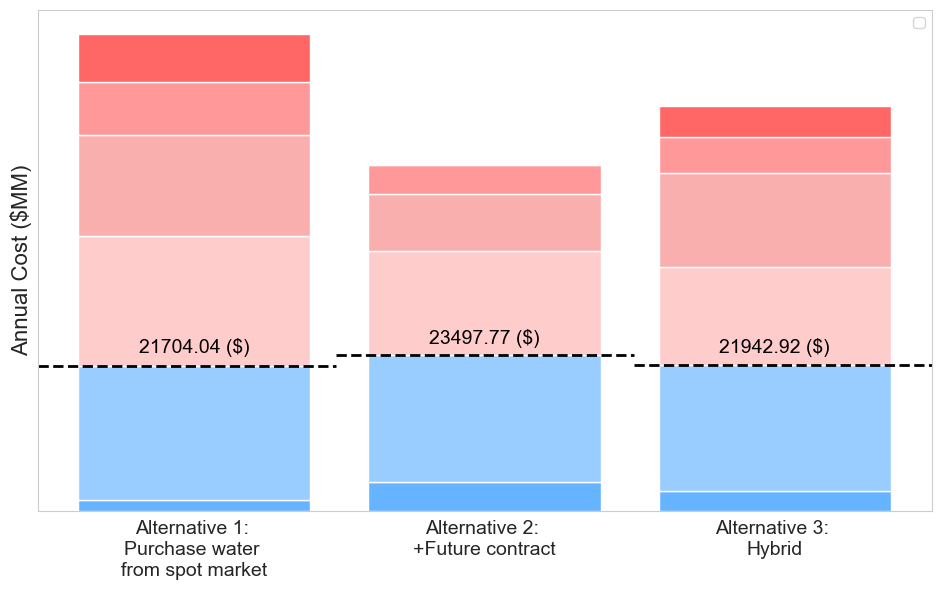

In [26]:
dataframes = {
    'Alternative 1: \nPurchase water \nfrom spot market': spot_costs.iloc[0, :],
    'Alternative 2: \n+Future contract': futures_costs.iloc[0, :],
    'Alternative 3: \nHybrid': hybrid_costs.iloc[0, :]
}

fig, ax = plt.subplots(figsize=(10, 6))

above_avg_colors = ['#ffcccc', '#faafaf', '#ff9999', '#ff6666', '#ff0000']  # Light to dark red
below_avg_colors = ['#0073e6', '#3399ff', '#66b3ff', '#99ccff', '#cce5ff']  # Dark to light blue

for x_pos, (label, data) in enumerate(dataframes.items()):
    average_cost = data.mean()
    percentiles = data.quantile([0.01, 0.05, 0.20, 0.80, 0.95, 0.99]).values
    p5, p10, p20, p80, p90, p95 = sorted(percentiles)
    
    # Define segment heights
    segments = [
        p5 - data.min(), p10 - p5, p20 - p10, p80 - p20,
        p90 - p80, p95 - p90, data.max() - p95
    ]
    segments = [max(0, height) for height in segments]  # Ensure no negative heights

    # Split below and above average segments
    below_segments = []
    above_segments = []
    bottom = 0
    for height in segments:
        if bottom + height <= average_cost:
            below_segments.append(height)
        elif bottom >= average_cost:
            above_segments.append(height)
        else:  # Crosses the average
            below_segments.append(average_cost - bottom)
            above_segments.append(height - (average_cost - bottom))
        bottom += height

    # Plot below-average segments
    bottom = 0
    for idx, height in enumerate(below_segments):
        ax.bar(x_pos, height, bottom=bottom, color=below_avg_colors[idx % len(below_avg_colors)])
        bottom += height

    # Plot above-average segments
    above_segments = sorted(above_segments, reverse=True)  # Reverse for darkest red at middle
    for idx, height in enumerate(above_segments):
        ax.bar(x_pos, height, bottom=bottom, color=above_avg_colors[idx % len(above_avg_colors)])
        bottom += height

    # Draw average line and annotate
    ax.axhline(y=average_cost, xmin=x_pos / len(dataframes), xmax=(x_pos + 1) / len(dataframes),
               color='black', linestyle='--', linewidth=2)
    ax.text(x_pos, average_cost + 0.02 * data.max(), f'{average_cost:.2f} ($)', color='black', ha='center', va='bottom', fontsize=14)

# Set labels and grid
ax.set_ylabel('Annual Cost ($MM)', fontsize=16)
ax.set_xticks(range(len(dataframes)))
ax.set_xticklabels(dataframes.keys(), fontsize=14)
plt.tight_layout()
plt.tick_params(left=False) 
plt.yticks([]) 
plt.legend()
plt.grid(False)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


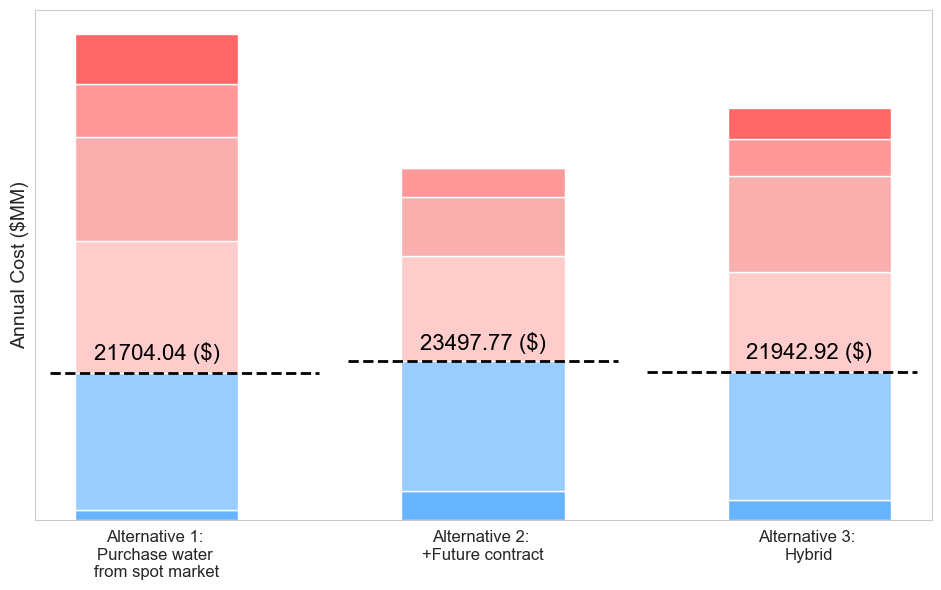

In [46]:
dataframes = {
    'Alternative 1: \nPurchase water \nfrom spot market': spot_costs.iloc[0, :],
    'Alternative 2: \n+Future contract': futures_costs.iloc[0, :],
    'Alternative 3: \nHybrid': hybrid_costs.iloc[0, :]
}

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as necessary

above_avg_colors = ['#ffcccc', '#faafaf', '#ff9999', '#ff6666', '#ff0000']  # Light to dark red
below_avg_colors = ['#0073e6', '#3399ff', '#66b3ff', '#99ccff', '#cce5ff']  # Dark to light blue

bar_width = 0.5  # Adjust bar width to make columns less wide

for x_pos, (label, data) in enumerate(dataframes.items()):
    average_cost = data.mean()
    percentiles = data.quantile([0.01, 0.05, 0.20, 0.80, 0.95, 0.99]).values
    p5, p10, p20, p80, p90, p95 = sorted(percentiles)

    # Define segment heights
    segments = [
        p5 - data.min(), p10 - p5, p20 - p10, p80 - p20,
        p90 - p80, p95 - p90, data.max() - p95
    ]
    segments = [max(0, height) for height in segments]  # Ensure no negative heights

    # Split below and above average segments
    below_segments = []
    above_segments = []
    bottom = 0
    for height in segments:
        if bottom + height <= average_cost:
            below_segments.append(height)
        elif bottom >= average_cost:
            above_segments.append(height)
        else:  # Crosses the average
            below_segments.append(average_cost - bottom)
            above_segments.append(height - (average_cost - bottom))
        bottom += height

    # Plot below-average segments
    bottom = 0
    for idx, height in enumerate(below_segments):
        ax.bar(x_pos, height, bottom=bottom, color=below_avg_colors[idx % len(below_avg_colors)], width=bar_width)
        bottom += height

    # Plot above-average segments
    above_segments = sorted(above_segments, reverse=True)  # Reverse for darkest red at middle
    for idx, height in enumerate(above_segments):
        ax.bar(x_pos, height, bottom=bottom, color=above_avg_colors[idx % len(above_avg_colors)], width=bar_width)
        bottom += height

    # Draw average line and annotate
    ax.axhline(y=average_cost, xmin=(x_pos - bar_width/2 +0.3) / len(dataframes), xmax=(x_pos + bar_width/2 +0.7) / len(dataframes),
               color='black', linestyle='--', linewidth=2)
    ax.text(x_pos, average_cost + 0.02 * data.max(), f'{average_cost:.2f} ($)', color='black', ha='center', va='bottom', fontsize=16)

# Set labels and grid
ax.set_ylabel('Annual Cost ($MM)', fontsize=14)
ax.set_xticks(range(len(dataframes)))
ax.set_xticklabels(dataframes.keys(), fontsize=12)
plt.tight_layout()
plt.tick_params(left=False) 
plt.yticks([]) 
ax.legend().remove()  # Removing the legend if not needed, change if required
plt.grid(False)
plt.show()